In [25]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import keras
import cv2
import time

In [26]:
import os, random

print('[INFO] RANDOMLY SELECTING IMAGE')
rand_select_img = []
rand_select_label = []

i = 0

aonan_data_path = os.listdir('datasets_VGG/aonan')
elf_data_path = os.listdir('datasets_VGG/elf')

while i <= 25 :
    rand_select_img.append(f'datasets_VGG/aonan/{random.choice(aonan_data_path)}')
    rand_select_label.append('aonan')
    rand_select_img.append(f'datasets_VGG/elf/{random.choice(elf_data_path)}')
    rand_select_label.append('elf')
    i+=1



i = 0
while i <= 50 : 
    rand_int = random.randint(1,5)
    unknown_data_path = f'datasets_VGG/unknown/{rand_int}'
    rand_choice = os.listdir(f'datasets_VGG/unknown/{rand_int}')
    path = f'{unknown_data_path}/{random.choice(rand_choice)}'
    rand_select_img.append(path)
    print(path)
    rand_select_label.append('unknown')
    i+=1
print(f'Image selected : {len(rand_select_img)} images')
print(f'Total label : {len(rand_select_img)} labels ')

[INFO] RANDOMLY SELECTING IMAGE
datasets_VGG/unknown/3/Selfie_1.jpg
datasets_VGG/unknown/2/ID_2.jpg
datasets_VGG/unknown/3/Selfie_8.jpg
datasets_VGG/unknown/3/Selfie_3.jpg
datasets_VGG/unknown/2/ID_1.jpg
datasets_VGG/unknown/1/Selfie_6.jpg
datasets_VGG/unknown/3/Selfie_12.jpg
datasets_VGG/unknown/4/Selfie_9.JPG
datasets_VGG/unknown/4/ID_1.jpg
datasets_VGG/unknown/4/Selfie_3.JPG
datasets_VGG/unknown/3/Selfie_7.jpg
datasets_VGG/unknown/2/Selfie_1.jpg
datasets_VGG/unknown/3/Selfie_13.jpg
datasets_VGG/unknown/5/Selfie_1.jpg
datasets_VGG/unknown/4/Selfie_6.JPG
datasets_VGG/unknown/2/Selfie_9.jpg
datasets_VGG/unknown/2/Selfie_9.jpg
datasets_VGG/unknown/5/Selfie_13.jpg
datasets_VGG/unknown/3/Selfie_6.jpg
datasets_VGG/unknown/1/Selfie_12.jpg
datasets_VGG/unknown/3/Selfie_9.jpg
datasets_VGG/unknown/1/Selfie_13.jpg
datasets_VGG/unknown/5/Selfie_1.jpg
datasets_VGG/unknown/2/Selfie_10.jpg
datasets_VGG/unknown/3/ID_2.jpg
datasets_VGG/unknown/1/Selfie_6.jpg
datasets_VGG/unknown/5/Selfie_1.jpg
datase

In [27]:
prob_model = load_model('./model/model_2025-09-04_1756974610.074763.tf')

In [28]:
name = ['aonan','elf','unknown']

In [29]:
sample_set = []
for img in rand_select_img :
    sample = cv2.imread(img)
    sample_set.append(sample)


In [30]:
def sample_process(sample) :
    sample_reshape = cv2.resize(sample,dsize=(224,224))
    sample = tf.convert_to_tensor(sample_reshape, dtype=tf.float32)
    sample = tf.expand_dims(sample, 0)
    return sample

In [31]:
sample_set_processed = []
for sample in sample_set :
    sample_e = sample_process(sample)
    sample_set_processed.append(sample_e)

In [32]:
sample_set_processed[0].shape

TensorShape([1, 224, 224, 3])

In [44]:
def decode_prediction(predictions, label):
    confidence = predictions[0][predictions[0].argmax()] * 100
    print(predictions[0][predictions[0].argmax()])
    if confidence > 80 : 
        return label[predictions[0].argmax()]
    else :
        return 'unknown'

In [45]:
pred_label = []
for sample in sample_set_processed :
    predictions = prob_model.predict(sample)
    pred_label.append(decode_prediction(predictions, name))
print(pred_label)

1/1 [==============================] - 0s 25ms/step
0.96270424
1/1 [==============================] - 0s 19ms/step
0.96109325
1/1 [==============================] - 0s 21ms/step
0.9810783
1/1 [==============================] - 0s 20ms/step
0.85825664
1/1 [==============================] - 0s 17ms/step
0.9365063
1/1 [==============================] - 0s 19ms/step
0.8297722
1/1 [==============================] - 0s 18ms/step
0.9673014
1/1 [==============================] - 0s 21ms/step
0.9514648
1/1 [==============================] - 0s 19ms/step
0.9743479
1/1 [==============================] - 0s 19ms/step
0.97373044
1/1 [==============================] - 0s 21ms/step
0.9674329
1/1 [==============================] - 0s 19ms/step
0.87661844
1/1 [==============================] - 0s 19ms/step
0.9806769
1/1 [==============================] - 0s 19ms/step
0.95326596
1/1 [==============================] - 0s 20ms/step
0.93722355
1/1 [==============================] - 0s 20ms/step
0.94443214


In [35]:
from sklearn import metrics
import matplotlib.pyplot as plt

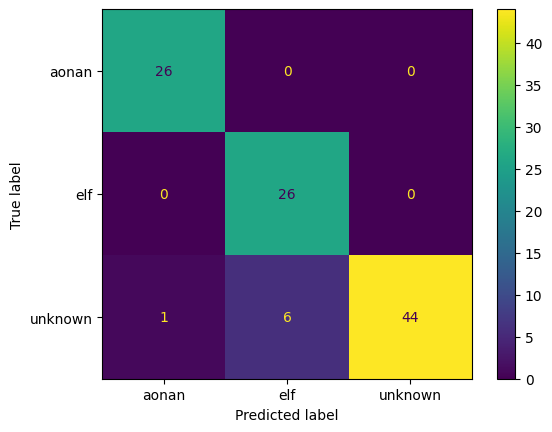

In [46]:
confusion_matrix = metrics.confusion_matrix(rand_select_label, pred_label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=name)
cm_display.plot()
plt.show()

### Real-Time recognition testing

In [37]:
import cv2, queue, threading, time

##### Custom-made video capture for using with CCTV

In [39]:
class VideoCapture:

  def __init__(self, name):
    self.cap = cv2.VideoCapture(name)
    self.q = queue.Queue()
    t = threading.Thread(target=self._reader)
    t.daemon = True
    t.start()

  def _reader(self):
    while True:
      ret, frame = self.cap.read()
      if not ret:
        break
      if not self.q.empty():
        try:
          self.q.get_nowait()
        except queue.Empty:
          pass
      self.q.put(frame)

  def read(self):
    return self.q.get()
  
  def release(self):
    self.cap.release()


In [40]:
cap = VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

color = (0, 255, 0)
fontsize = 2

while(True):
    img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(10, 10)
    )
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
        predictions = prob_model.predict(sample_process(img[y:y+h,x:x+w]), verbose=0)
        id = predictions[0].argmax()
        confidence = predictions[0][predictions[0].argmax()] * 100
        if (confidence > 75):
            id = name[id]
            cv2.putText(
                    img, 
                    str(id), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
            cv2.putText(
                    img, 
                    str(confidence), 
                    (x+5,y+h-5), 
                    font, 
                    1, 
                    (255,255,0), 
                    1
                   )  
        else:
            id = "unknown"
            cv2.putText(
                    img, 
                    str(id), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
        
    cv2.imshow('camera',img)
    k = cv2.waitKey(10) & 0xff
    if k == 27:
        break
print("\n [INFO] Exiting Program and cleanup stuff")
cap.release()
cv2.destroyAllWindows()


 [INFO] Exiting Program and cleanup stuff


In [ ]:
pip install windows-capture-device-list

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for windows-capture-device-list: filename=windows_capture_device_list-1.1.0-py3-none-any.whl size=3555 sha256=460a2e28792d40833188de1ed7b5a216908f97e96dc5e958e6d64120d95fea77
  Stored in directory: /home/phanxv/.var/app/com.visualstudio.code/cache/pip/wheels/80/04/d8/3d85b7688d48be2d1f975a8ba6da1569a92dd1622d4e1bfec1
Successfully built windows-capture-device-list
Note: you may need to restart the kernel to use updated packages.
